In [ ]:
#demand
import pandas as pd
import os
import glob
from pathlib import Path

csvs = []
parent_dir = 'demand'
for csv_file in glob.glob(os.path.join(parent_dir, '*.csv')):
    csvs.append(csv_file)

files = []
li = []
for filename in sorted(csvs):
    files.append(Path(os.path.splitext(filename)[0]).stem)
    df = pd.read_csv(filename, index_col=None, header=0)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
os.makedirs('Data', exist_ok=True)  
df.to_csv('Data/demand.csv')  
df.head()

files = list(map(int, files))
# print(*files[:5], sep='\n')
print(len(files))
print('size: ', df.size, sep='')

1096
size: 1262592


In [ ]:
df = pd.read_csv('Data/demand.csv')
df = df.drop(columns='Unnamed: 0')

f_files = []
for f in files:
  for i in range(288):
    f_files.append(f)


print(len(f_files))
df['files'] = f_files

df.head(289)

315648


,Time,Day ahead forecast,Hour ahead forecast,Current demand,files
0,00:00,23437.0,22290.0,22216.0,20190101
1,00:05,22363.0,22089.0,22106.0,20190101
2,00:10,22363.0,22089.0,22130.0,20190101
3,00:15,22363.0,22089.0,22040.0,20190101
4,00:20,22363.0,21867.0,21963.0,20190101
...,...,...,...,...,...
284,23:40,22495.0,22133.0,22096.0,20190101
285,23:45,22495.0,22133.0,21961.0,20190101
286,23:50,22495.0,21813.0,21838.0,20190101
287,23:55,22495.0,21813.0,21716.0,20190101


In [ ]:
import datetime
df['Time'] = df['Time'] + ':00'
df['date'] = df['files'].astype(str) + df['Time']

df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

In [ ]:
df = df.drop(columns=['Time', 'files'])
df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00


In [ ]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
df.isna().sum()

Day ahead forecast     0
Hour ahead forecast    0
Current demand         0
date                   0
dtype: int64

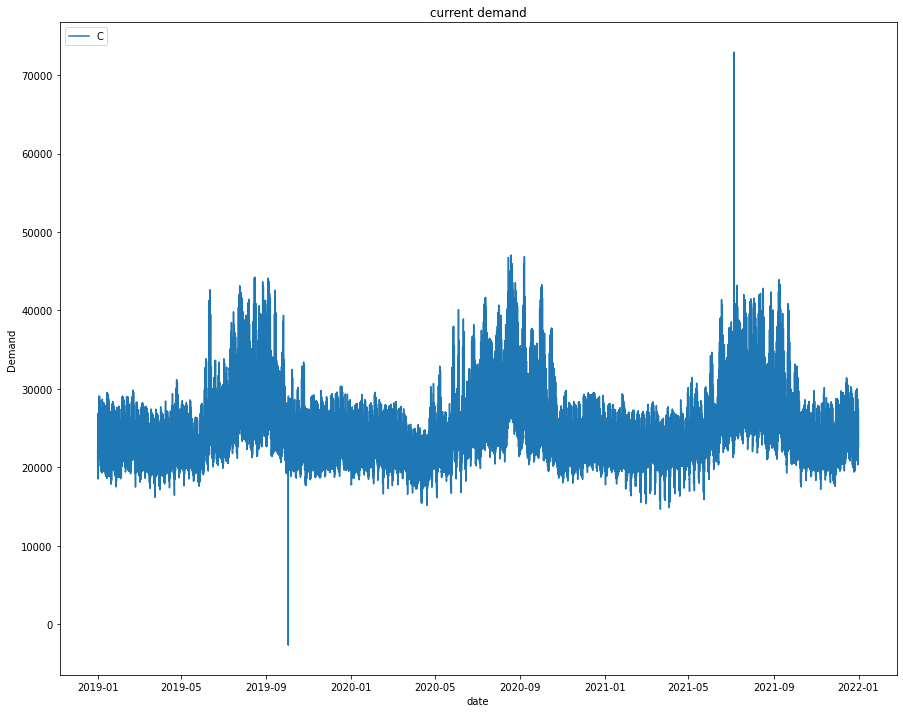

In [ ]:
from matplotlib import pyplot as plt
from datetime import datetime as dt
import matplotlib.dates as md
from pandas import Timedelta as td

%matplotlib inline

plt.figure(figsize=(15,12))
plt.plot(df['date'], df['Current demand'])
plt.title('current demand')
plt.ylabel('Demand')
plt.xlabel('date')
plt.legend('Current Demand', loc='upper left')

plt.show()
print('\n')

# # plt.figure(figsize=(15,12))
# plt.plot(df['date'], df['Day ahead forecast'])
# plt.title('Day ahead forecast')
# plt.ylabel('Demand')
# plt.xlabel('date')
# plt.legend('Day ahead forecast', loc='upper left')

# plt.show()
# print('\n')

# # plt.figure(figsize=(15,12))
# plt.plot(df['date'], df['Hour ahead forecast'])
# plt.title('hour ahead forecast')
# plt.ylabel('Demand')
# plt.xlabel('date')
# plt.legend('Hour Ahead Forecast', loc='upper left')

# plt.show()

In [ ]:
#checks availability of data
import missingno as msno

msno.bar(df)          

In [ ]:
#finds correlation between data
import seaborn as sns

plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2g', cmap='coolwarm')
plt.xticks(rotation='horizontal')

In [ ]:
#makes each date information into a new collumn, year, month, etc
df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day            
df['date_hour'] = df['date'].dt.hour
df['date_min'] = df['date'].dt.minute
df['date_sec'] = df['date'].dt.second

df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date,date_year,date_month,date_day,date_hour,date_min,date_sec
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00,2019,1,1,0,0,0
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00,2019,1,1,0,5,0
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00,2019,1,1,0,10,0
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00,2019,1,1,0,15,0
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00,2019,1,1,0,20,0


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df['date'].values.reshape(-1,1)
y = df['Current demand']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


from sklearn.ensemble import IsolationForest    #finds outliers in dataset

iso = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.2), max_features=1.0)
iso.fit(df[['Current demand']])

df['outliers'] = iso.predict(df[['Current demand']])

indexer = []
indexer.append(df[df['outliers']==-1].index)

for i in indexer:
  print(df.loc[i,'date'])



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


135      2019-01-01 11:15:00
137      2019-01-01 11:25:00
138      2019-01-01 11:30:00
139      2019-01-01 11:35:00
140      2019-01-01 11:40:00
                 ...        
315014   2021-12-29 19:10:00
315015   2021-12-29 19:15:00
315016   2021-12-29 19:20:00
315017   2021-12-29 19:25:00
315018   2021-12-29 19:30:00
Name: date, Length: 63096, dtype: datetime64[ns]


In [ ]:
from sklearn.cluster import KMeans

k_rng = range(1,10)
sse = []

for k in k_rng:
  km = KMeans(n_clusters=k)
  km.fit(df['date'].values.reshape(-1,1), df['Current demand'])
  sse.append(km.inertia_)

sse

[2.358687411079672e+38,
 5.896884179986629e+37,
 2.621728173760204e+37,
 1.474563269565601e+37,
 9.454196739102117e+36,
 6.559184609585751e+36,
 4.830799152922739e+36,
 3.687767224429925e+36,
 2.9194974521215216e+36]

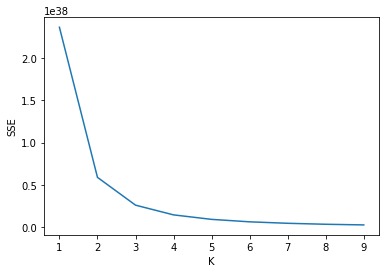

In [ ]:
#elbow method for number of kmeans clusters
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng, sse)

In [ ]:
#resamples the data per year, week, anything we want to see
df_resampled = df.set_index('date')
# print(df_resampled.columns)

df_yearly = df_resampled['Current demand'].resample('AS').mean()   #yearly
df_yearly.columns = ['date', 'demand']
df_monthly = df_resampled['Current demand'].resample('M').mean()    #monthly
df_monthly.columns = ['date', 'demand']
df_weekly = df_resampled['Current demand'].resample('W').mean()   #weekly
df_weekly.columns = ['date', 'demand']

df_daily = df_resampled['Current demand'].resample('D').mean()   #daily
df_daily.columns = ['date', 'demand']

# y_df_daily = df_resampled['Day ahead forecast'].resample('D').mean()   #daily
# y_df_daily.columns = ['date', 'Day ahead forecast']

df_hourly = df_resampled['Current demand'].resample('H').mean()   #hourly
df_hourly.columns = ['date', 'demand']

# print(X_df_daily.columns, y_df_daily.columns)
df_daily

date
2019-01-01    21812.465278
2019-01-02    24134.614583
2019-01-03    24751.847222
2019-01-04    24432.812500
2019-01-05    23862.239583
                  ...     
2021-12-27    24566.732639
2021-12-28    25070.687500
2021-12-29    25498.704861
2021-12-30    24393.045139
2021-12-31    22803.527778
Freq: D, Name: Current demand, Length: 1096, dtype: float64

In [ ]:
#resample figs
fig, ax = plt.subplots(figsize=(15,12))

ax.plot(df_monthly.index, df_monthly, color='blue')
ax.set_ylabel('Monthly Demand')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.plot(df_weekly.index, df_weekly, color='green')
ax2.set_ylabel('Weekly Demand')


# ax3 = ax.twinx()
# ax3.plot(df_daily.index, df_daily, color='red')

# ax4 = ax.twinx()
# ax4.plot(df_hourly.index, df_hourly, color='purple')

fig.legend(['Resampled Monthly Demand', 'Resampled Weekly Demand'], loc='upper right')
fig.show()

In [ ]:
plt.figure(figsize=(15,12))
plt.scatter(X,y, marker='+')

In [ ]:
from sklearn.model_selection import train_test_split


X = df_daily.index
y = df_daily.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# enc.fit(X_train)

# km = KMeans(n_clusters=8)

# km.fit_predict(str(X_train), y_train)

from sklearn.svm import SVR

SVReg = SVR(kernel='rbf')

SVReg.fit(X_train.values.reshape(-1,1), y_train)

In [1]:
#sources
import pandas as pd
import os
import glob
from pathlib import Path

csvs_2 = []
parent_dir_2 = 'sources'
for csv_file in glob.glob(os.path.join(parent_dir_2, '*.csv')):
    csvs_2.append(csv_file)

files_2 = []
li_2 = []
for filename in sorted(csvs_2):
    files_2.append(Path(os.path.splitext(filename)[0]).stem)
    s_df = pd.read_csv(filename, index_col=None, header=0)
    # if len(s_df)!=288:
      # print(len(s_df))
    if len(s_df)>288:  
      s_df.drop(s_df.tail(1).index,inplace=True)
      # print(len(s_df))
      # print(s_df.Time)
    elif len(s_df)<288:
      # print(len(s_df))
      if len(s_df)==287:
        s_df2 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df2], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==286:
        s_df3 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df3 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==285:
        s_df4 = pd.DataFrame({'Time':['23:45']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==277:
        s_df5 = pd.DataFrame({'Time':['23:05']})
        s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
        # minutes = 10
        # print(minutes)
        for minutes in range(10,60,5):
          s_df5 = pd.DataFrame({'Time':['23:'+str(minutes)]})
          s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
          # minutes+=5
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
    li_2.append(s_df)

s_df = pd.concat(li_2, axis=0, ignore_index=True)
os.makedirs('Sources_Data', exist_ok=True)  
s_df.to_csv('Sources_Data/sources.csv')  

print('files: ', len(files_2), sep='')
print('length of df: ', len(s_df), sep='')
# s_df.head(288)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

files: 1096
length of df: 315648


In [2]:
s_df = pd.read_csv('Sources_Data/sources.csv')
s_df = s_df.drop(columns='Unnamed: 0')

f_files_2 = []
for f in files_2:
  for i in range(288):
    f_files_2.append(f)


print(len(f_files_2))
s_df['files'] = f_files_2

s_df.head()

315648


,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro,files
0,00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0,NaN,NaN,20190101
1,00:05,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0,NaN,NaN,20190101
2,00:10,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0,NaN,NaN,20190101
3,00:15,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0,NaN,NaN,20190101
4,00:20,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0,NaN,NaN,20190101


In [3]:
import datetime
s_df['Time'] = s_df['Time'] + ':00'
s_df['date'] = s_df['files'].astype(str) + s_df['Time']

s_df['date'] = s_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

In [4]:
s_df = s_df.drop(columns=['Time', 'files'])
# s_df = s_df.drop(columns=['files'])
s_df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro,date
0,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0,NaN,NaN,2019-01-01 00:00:00
1,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0,NaN,NaN,2019-01-01 00:05:00
2,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0,NaN,NaN,2019-01-01 00:10:00
3,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0,NaN,NaN,2019-01-01 00:15:00
4,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0,NaN,NaN,2019-01-01 00:20:00


In [5]:
s_df = s_df.apply(lambda x: x.fillna(x.mean()),axis=0)
s_df.isna().sum()

Solar          0
Wind           0
Geothermal     0
Biomass        0
Biogas         0
Small hydro    0
Coal           0
Nuclear        0
Natural gas    0
Large hydro    0
Batteries      0
Imports        0
Other          0
Natural Gas    0
Large Hydro    0
date           0
dtype: int64

In [6]:
#makes each date information into a new collumn, year, month, etc
s_df['date_year'] = s_df['date'].dt.year
s_df['date_month'] = s_df['date'].dt.month
s_df['date_day'] = s_df['date'].dt.day            
s_df['date_hour'] = s_df['date'].dt.hour
s_df['date_min'] = s_df['date'].dt.minute
s_df['date_sec'] = s_df['date'].dt.second

s_df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,...,Other,Natural Gas,Large Hydro,date,date_year,date_month,date_day,date_hour,date_min,date_sec
0,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:00:00,2019,1,1,0,0,0
1,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:05:00,2019,1,1,0,5,0
2,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:10:00,2019,1,1,0,10,0
3,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:15:00,2019,1,1,0,15,0
4,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:20:00,2019,1,1,0,20,0


In [7]:
#resamples the data per year, week, anything we want to see
s_df_resampled = s_df.set_index('date')
print(s_df_resampled.columns)


coal_df_minute = s_df_resampled['Coal'].resample('T').mean()    #resample in 5 minute frequency
# print(coal_df_minute.size)

natural_gas_df_minute = s_df_resampled['Natural gas'].resample('T').mean()   
natural_gas_df_minute = natural_gas_df_minute.interpolate(method='pad')
natural_gas_df_minute = natural_gas_df_minute.reset_index()
natural_gas_df_minute.columns = ['date', 'natural gas']

coal_df_minute = s_df_resampled['Coal'].resample('T').mean()   
coal_df_minute = coal_df_minute.interpolate(method='pad')
coal_df_minute = coal_df_minute.reset_index()
coal_df_minute.columns = ['date', 'coal']

batteries_df_minute = s_df_resampled['Batteries'].resample('T').mean()   
batteries_df_minute = batteries_df_minute.interpolate(method='pad')
batteries_df_minute = batteries_df_minute.reset_index()
batteries_df_minute.columns = ['date', 'batteries']

coal_df_minute

Index(['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro',
       'Coal', 'Nuclear', 'Natural gas', 'Large hydro', 'Batteries', 'Imports',
       'Other', 'Natural Gas', 'Large Hydro', 'date_year', 'date_month',
       'date_day', 'date_hour', 'date_min', 'date_sec'],
      dtype='object')


,date,coal
0,2019-01-01 00:00:00,11.0
1,2019-01-01 00:01:00,11.0
2,2019-01-01 00:02:00,11.0
3,2019-01-01 00:03:00,11.0
4,2019-01-01 00:04:00,11.0
...,...,...
1578231,2021-12-31 23:51:00,20.0
1578232,2021-12-31 23:52:00,20.0
1578233,2021-12-31 23:53:00,20.0
1578234,2021-12-31 23:54:00,20.0


In [8]:
master_df = natural_gas_df_minute
master_df['coal'] = coal_df_minute['coal']
master_df['batteries'] = batteries_df_minute['batteries']
master_df

X = master_df['date']
y = natural_gas_df_minute['natural gas']
# y = master_df.drop(columns=['date'])
print(X.shape[0])
print(y.shape)
y

# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(natural_gas_df_minute)
# f = scaler.transform(natural_gas_df_minute)
# f

1578236
(1578236,)


0          7326.000000
1          7326.000000
2          7326.000000
3          7326.000000
4          7326.000000
              ...     
1578231    8101.128168
1578232    8101.128168
1578233    8101.128168
1578234    8101.128168
1578235    8101.128168
Name: natural gas, Length: 1578236, dtype: float64

TEST WITH TIMESPAMP

In [154]:
coal_df_minute
train = coal_df_minute[:157800]
test = coal_df_minute[:157800]

# train = train.to_numpy()
# train[1]

df = coal_df_minute

def time_manager(df): 
  time = []
  for i in df.date:
    # print(i.timestamp())
    # print(i.to_pydatetime())
    # print(i)
    time.append(i.timestamp())
  df['time'] = time
  # df = df.drop(['date'], axis=1)
  return df


df = time_manager(df)
df



,date,coal,time
0,2019-01-01 00:00:00,11.0,1.546301e+09
1,2019-01-01 00:01:00,11.0,1.546301e+09
2,2019-01-01 00:02:00,11.0,1.546301e+09
3,2019-01-01 00:03:00,11.0,1.546301e+09
4,2019-01-01 00:04:00,11.0,1.546301e+09
...,...,...,...
1578231,2021-12-31 23:51:00,20.0,1.640995e+09
1578232,2021-12-31 23:52:00,20.0,1.640995e+09
1578233,2021-12-31 23:53:00,20.0,1.640995e+09
1578234,2021-12-31 23:54:00,20.0,1.640995e+09


In [155]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(df[['coal', 'time']])
df = scaler.transform(df[['coal', 'time']])
df

array([[5.00000000e-01, 0.00000000e+00],
       [5.00000000e-01, 6.33619202e-07],
       [5.00000000e-01, 1.26723840e-06],
       ...,
       [7.36842105e-01, 9.99998733e-01],
       [7.36842105e-01, 9.99999366e-01],
       [7.10526316e-01, 1.00000000e+00]])

In [219]:
df = pd.DataFrame(df)
df.columns = ['coal', 'time']
df = df.reindex(columns=['time', 'coal'])
df

,time,coal
0,0.500000,0.000000e+00
1,0.500000,6.336192e-07
2,0.500000,1.267238e-06
3,0.500000,1.900858e-06
4,0.500000,2.534477e-06
...,...,...
1578231,0.736842,9.999975e-01
1578232,0.736842,9.999981e-01
1578233,0.736842,9.999987e-01
1578234,0.736842,9.999994e-01


In [203]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 200
n_features = 1
generator = TimeseriesGenerator(df.coal, df.coal, length=n_input, batch_size=1)


In [218]:
X, y = generator[1]
print(X.shape)
print(y.shape)

(1, 200)
(1,)


TEST WITH AUTOENCODERS

In [11]:
# df2 = coal_df_minute.drop(['time'], axis=1)
df2 = coal_df_minute
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(df2[['coal']])

In [12]:
df2['coal'] = scaler.transform(df2[['coal']])
df2

,date,coal
0,2019-01-01 00:00:00,-0.709222
1,2019-01-01 00:01:00,-0.709222
2,2019-01-01 00:02:00,-0.709222
3,2019-01-01 00:03:00,-0.709222
4,2019-01-01 00:04:00,-0.709222
...,...,...
1578231,2021-12-31 23:51:00,1.258276
1578232,2021-12-31 23:52:00,1.258276
1578233,2021-12-31 23:53:00,1.258276
1578234,2021-12-31 23:54:00,1.258276


In [16]:
import numpy as np

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

In [17]:
TIME_STEPS = 30

X, y = create_dataset(df2[['coal']], df2.coal, TIME_STEPS)
# df2[['coal']]
# df2.coal

In [25]:
X.shape
X = X[:10000]
y = y[:10000]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.4068 - mse: 0.2388
Epoch 1: mse improved from -inf to 0.23881, saving model to best_m.h5
11/11 [==============================] - 7s 150ms/step - loss: 0.4068 - mse: 0.2388 - val_loss: 0.3163 - val_mse: 0.1536
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.2849 - mse: 0.1254
Epoch 2: mse did not improve from 0.23881
11/11 [==============================] - 1s 70ms/step - loss: 0.2849 - mse: 0.1254 - val_loss: 0.2649 - val_mse: 0.1044
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2510 - mse: 0.0993
Epoch 3: mse did not improve from 0.23881
11/11 [==============================] - 1s 67ms/step - loss: 0.2510 - mse: 0.0993 - val_loss: 0.2345 - val_mse: 0.0899
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.2395 - mse: 0.0894
Epoch 4: mse did not improve from 0.23881
11/11 [==============================] - 1s 72ms/step - loss: 0.2395 - mse: 0.0894 - va

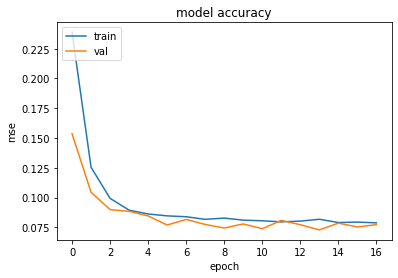

In [29]:
from tensorflow import keras
from keras.optimizers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)       #Splits data into train, test


# opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)
opt = keras.optimizers.Adam()


model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
# model.add(Dense(1))

model.compile(
optimizer=opt,
# loss='binary_crossentropy',
# loss='mean_squared_error',
loss='mae',
# metrics=[rmse]
# metrics=['binary_accuracy']
metrics=['mse']
)

es = EarlyStopping(             #Early stopping
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='min'
)

mc = ModelCheckpoint(       #Model checkpoint to save best model each epoch
    'best_m.h5',
    monitor='mse',
    mode='max',
    verbose=1,
    save_best_only=True
)

history = model.fit(X_train, y_train,           #Model fit
          validation_data=(X_test, y_test),
          epochs=50,
          callbacks=[es, mc],
          verbose=1)

print('val_loss, val_acc: ', model.evaluate(X_test, y_test), sep='')        #Model evaluation

scores = model.evaluate(X_test, y_test, verbose=0)
# rmseList.append(scores[0])
print("Fold :", i+1, " loss", scores[0])

plt.plot(history.history['mse'])            #Plots accuracy, val_accuracy/epoch graph
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()